In [133]:
import astroprov
from astropy.io import fits
from astropy.io.ascii import SExtractor
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils import aperture_photometry
#import subproc

import numpy as np
from astropy import wcs
from astropy.io import fits
import sys

from astroquery.simbad import Simbad

import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.table import Table
from astropy.table import Column

import collections

In [3]:
imagedirectory = '/home/mj1e16/keplerImages'

newImagelist = []
Image = os.listdir(imagedirectory)
for i, item in enumerate(Image):
    if item.find('.fits') != -1:
        #print(i,Image[i].find('.fits'))
        newImagelist.append(item)
Image = newImagelist


FWHM = 5.0
MinSep = 0.8 #sets value for discriminating sources
N = len(Image) #number of images minus 1 as it starts from zero
imno = 0
imagedata = []
sources = dict()
Date = []
STD = []
Median = []


os.chdir(imagedirectory)
def daoStarFinder(imagenumber):
    """
    Locates and measures the brightness of all objects in the image as well as the sky background
    and other image data.

    :param imagenumber: Position of image in directory
    :return: Table of object data, date of observation, image data for backround calculation
    """
    print(Image[imagenumber])
    hdu_list = fits.open(Image[imagenumber]) # open image header
    imagedata = (hdu_list[0].data) 
    mean, median, std = sigma_clipped_stats(imagedata, sigma=3.0, iters=5) 
    Median.append(median)
    STD.append(std)
    daofind = DAOStarFinder(fwhm=FWHM, threshold=5.*std) # iraf star finder 
    Sources = daofind(imagedata - median)
    #Date = (hdu_list[0].header['MJD'])
    output = {}
    output[0] = Sources
    output[1] = Date
    output[2] = imagedata
    
    fig, ax = plt.subplots(figsize=(10, 10))
    positions = (output[0]['xcentroid'], output[0]['ycentroid'])
    apertures = CircularAperture(positions, r=4.)
    norm = ImageNormalize(stretch=SqrtStretch())
    ax.imshow(imagedata, cmap='Greys', origin='lower', vmin=-100,vmax=100)#norm=norm)
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    plt.savefig('fits.png',dpi=100)
    plt.show()
    
    
    
#     os.chdir(bindingsdirectory)
#     astroprov.provcall([imagenumber],[output[0],output[1],output[2]],"daoStarFinder_PythonCode2Images_SQ_tmpl.provn","daoStarFinder")
#     os.chdir(imagedirectory)
    return output




In [ ]:
def sextractor():
    sub

In [4]:
def load_wcs_from_file(filename,pixCoord):
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
    print(w.wcs.name)

    # Print out all of the settings that were parsed from the header
    w.wcs.print_contents()

    # Three pixel coordinates of interest.
    # Note we've silently assumed a NAXIS=2 image here.
    # Note also that the pixel coordinates are pairs of [X, Y], 
    # and since WCS built from FITS header automatically has
    # origin set to 1, [0, 0] is actually not inside the image.
    pixcrd = np.array(pixCoord, dtype=np.float_)

    # Convert pixel coordinates to world coordinates
    # The second argument is "origin" -- in this case we're declaring we
    # have 1-based (Fortran-like) coordinates.
    world = w.wcs_pix2world(pixcrd, 1)
    print(world)
    return(world)
#     # Convert the same coordinates back to pixel coordinates.
#     pixcrd2 = w.wcs_world2pix(world, 1)
#     print(pixcrd2)

#     # These should be the same as the original pixel coordinates, modulo
#     # some floating-point error.
#     assert np.max(np.abs(pixcrd - pixcrd2)) < 1e-6




In [153]:
def queryObjectRegion(outputTable,imageName):
    imageCoords = []
    r = 1*u.arcminute
    
    tableLength = outputTable['id'][-1]
    for x in range(tableLength):
        xpos = outputTable['xcentroid'][x]
        ypos = outputTable['ycentroid'][x]
        if 20 < ypos < 1040:
            if 12 < xpos < 1110:
                imageCoords.append([xpos,ypos])
                # this may need to change per image but I hope not

    coords = load_wcs_from_file(imageName,imageCoords)
    
    print(imageCoords)
    customSimbad = Simbad()
    customSimbad.add_votable_fields('ra(d)','dec(d)','otype')
    customSimbad.remove_votable_fields('coordinates')
            
    result_table = Table([['-'],[0],[0],['-'],[0],[0]],names=('MAIN_ID','RA_d','DEC_d','OTYPE','xcentroid','ycentroid'),dtype=('object','float64','float64','object','float64','float64'))

    for x in range(len(imageCoords)):
        try:
            c = SkyCoord(coords[x][0],coords[x][1],frame='icrs',unit='deg')
            rt = customSimbad.query_region(c,radius=r)
            rowlist = []
            for y in range(len(rt[0])):
                rowlist.append(rt[0][y])
            rowlist.append(imageCoords[x][0])
            rowlist.append(imageCoords[x][1])
            result_table.add_row(rowlist)

        except:
            result_table.add_row(['N/A',[0],[0],'Possible Transient',[imageCoords[x][0]],[imageCoords[x][1]]])
    
    hdu_list = fits.open(imageName)
    imagedata = (hdu_list[0].data) 
    fig, ax = plt.subplots(figsize=(10, 10))
    positions = (outputTable['xcentroid'], outputTable['ycentroid'])
    apertures = CircularAperture(positions, r=4.)
    norm = ImageNormalize(stretch=SqrtStretch())
    ax.imshow(imagedata, cmap='Greys', origin='lower', vmin=-100,vmax=100)#norm=norm)
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    #plt.savefig('fits.png',dpi=100)
    plt.show()
    
    return result_table

In [ ]:
def findObjectOccurences(inputTable,columnName):
    otype = inputTable[columnName]
    otypelist = []
    for x in range(len(otype)):
        otypelist.append(otype[x])
    #print(len(otypelist))
    newotype = set(otypelist)
    counter = collections.Counter(otypelist)
    keys = counter.keys()
    values = counter.values()
    occurenceDict = dict(zip(keys,values))
    return occurenceDict

In [4]:
def sextractor(sextractoryDir,imagename,cataloguename):
    os.chdir(sextractoryDir)
    subprocess.call(['sex',imagename])
    assoc = Table.read(cataloguename,format='ascii.sextractor')

#     fig, ax = plt.subplots(figsize=(10, 10))
#     positions = (setable['X_IMAGE'], setable['Y_IMAGE'])
#     apertures = CircularAperture(positions, r=4.)
#     norm = ImageNormalize(stretch=SqrtStretch())
#     ax.imshow(imagedata, cmap='Greys', origin='lower', vmin=-100,vmax=100)#norm=norm)
#     apertures.plot(color='blue', lw=1.5, alpha=0.5)
#     #plt.savefig('fits.png',dpi=100)
#     plt.show()
    return assoc

In [5]:
dirlist[1]

NameError: name 'dirlist' is not defined

In [ ]:
sextractor('/home/mj1e16/sextractor/sextractor-master/config/',)

difkplr2009115080620_ffi-cal57.fits


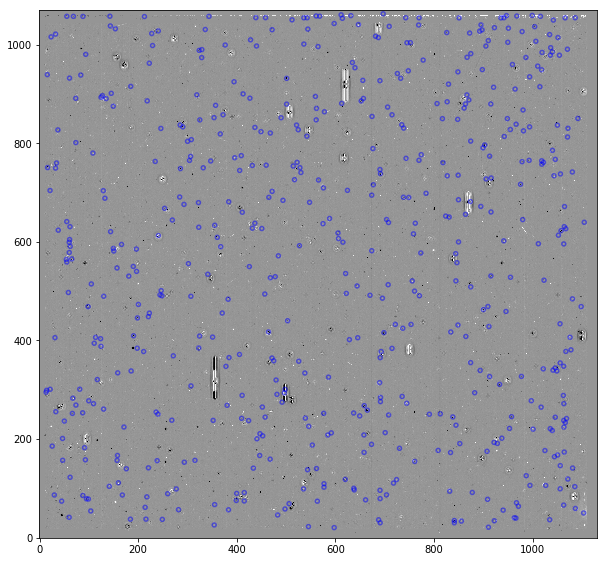

In [6]:
sources = {}
Date = {}
imagedata = {}
N = 1
for x in range(N):
    output = daoStarFinder(x)
    sources[x] = output[0]
    Date[x] = output[1]
    imagedata[x] = output[2]
#os.chdir(bindingsdirectory) 

difkplr2009115080620_ffi-cal57.fits


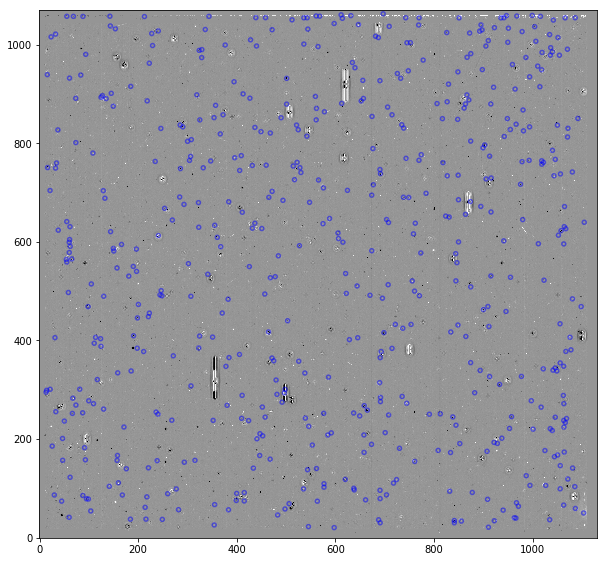

In [7]:
output = daoStarFinder(x)
sources[x] = output[0]
Date[x] = output[1]
imagedata[x] = output[2]


[[293.5787304   47.74496033]
 [293.13821043  47.56749714]
 [293.65059772  47.77641567]
 ...
 [293.35680197  48.96731172]
 [292.45961724  48.60947896]
 [292.28011989  48.53615779]]
[[597.6233512613425, 20.15880520487267], [910.6143403168055, 20.970033989267286], [545.4766473925444, 22.18647280771546], [354.25688563260917, 25.533997621700365], [690.9898124571824, 29.93690728807214], [841.4058779949274, 29.950427588222173], [855.7220569154483, 33.47881096561611], [841.3475074896459, 34.61172145685849], [922.5092473775792, 34.026529270172226], [687.8029191125012, 35.92991383874445], [1034.8780323603257, 36.133052295086294], [215.89691909408577, 37.344714899948016], [248.97083539712125, 36.86971043525276], [184.28550872738066, 37.276313880328125], [60.02187298631989, 41.00347490416009], [963.0918763944987, 40.21398549075858], [966.3388806548021, 39.43164435035686], [482.98846424228105, 45.832568918535436], [1103.746685034214, 49.79859848698939], [103.86813943874166, 53.91546647240631], [28

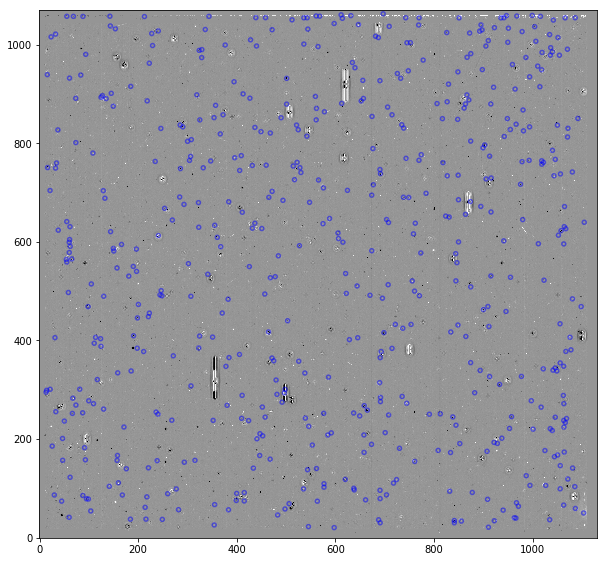

In [155]:
result_table = queryObjectRegion(output[0],dirlist[1])

In [ ]:
otypes = findObjectOccurences(result_table,'OTYPE')